# 卷积神经网络（LeNet）
:label:`sec_lenet`


通过之前几节，我们学习了构建一个完整卷积神经网络的所需组件。
回想一下，之前我们将 softmax 回归模型（ :numref:`sec_softmax_scratch` ）和多层感知机模型（ :numref:`sec_mlp_scratch` ）应用于 Fashion-MNIST 数据集中的服装图片上。
为了能够应用 softmax 回归和多层感知机，我们首先将每个大小为 $28\times28$ 的图像展平为一个 784 固定长度的一维向量，然后用全连接层对其进行处理。
而现在，我们已经掌握了卷积层的处理方法，我们可以在图像中保留空间结构。
同时，用卷积层代替全连接层的另一个好处是：更简洁的模型所需的参数更少。

在本节中，我们将介绍 LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。
这个模型是由 AT&T 贝尔实验室的研究员 Yann LeCun 在1989年提出的（并以其命名），目的是识别图像 :cite:`LeCun.Bottou.Bengio.ea.1998` 中的手写数字。
当时，Yann LeCun 发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

当时， LeNet 取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。
LeNet 被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。
时至今日，一些自动取款机仍在运行 Yann LeCun 和他的同事 Leon Bottou 在上世纪90年代写的代码呢！

## LeNet

总体来看，LeNet (LeNet-5) 由两个部分组成：

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。

该结构在 :numref:`img_lenet` 中所展示。

![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](../img/lenet.svg)
:label:`img_lenet`

每个卷积块中的基本单元是一个卷积层、一个 sigmoid 激活函数和平均池化层。请注意，虽然 ReLU 和最大池化层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用 $5\times 5$ 卷积核，这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有 6 个输出通道，而第二个卷积层有 16 个输出通道。每个 $2\times2$ 池操作（步骤2）通过空间下采样将维数减少 4 倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet 的稠密块有三个全连接层，分别有 120、84 和 10 个输出。因为我们仍在执行分类，所以输出层的 10 维对应于最后输出结果的数量。

通过下面的 LeNet 代码，你会相信用深度学习框架实现此类模型非常简单。我们只需要实例化一个 `Sequential` 块并将需要的层连接在一起。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5,
                                               padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的 LeNet-5 一致。

下面，我们将一个大小为 $28 \times 28$ 的单通道（黑白）图像通过 LeNet。 通过在每一层打印输出的形状，我们可以检查模型，以确保其操作与我们期望的 :numref:`img_lenet_vert` 一致。

![LeNet 的简化版。](../img/lenet-vert.svg)
:label:`img_lenet_vert`


In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


请注意，在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。
第一个卷积层使用 2 个像素的填充，来补偿 $5 \times 5$ 卷积核导致的特征减少。
相反，第二个卷积层没有填充，因此高度和宽度都减少了 4 个像素。
随着层叠的上升，通道的数量从输入时的 1 个，增加到第一个卷积层之后的 6 个，再到第二个卷积层之后的 16 个。
同时，每个池化层的高度和宽度都减半。最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。


## 模型训练

现在我们已经实现了 LeNet ，让我们看看这个模型在 Fashion-MNIST 数据集上的表现。


In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。
如果你有机会使用GPU，可以用它加快训练。


为了进行评估，我们需要对 :numref:`sec_softmax_scratch` 中描述的 `evaluate_accuracy` 函数进行轻微的修改。
由于完整的数据集位于内存中，因此在模型使用 GPU 计算数据集之前，我们需要将其复制到显存中。


In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使用 GPU，我们还需要一点小改动。
与 :numref:`sec_softmax_scratch` 中定义的 `train_epoch_ch3` 不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如 GPU）上。

如下所示，训练函数 `train_ch6` 也类似于 :numref:`sec_softmax_scratch` 中定义的 `train_ch3` 。
由于我们将实现多层神经网络，因此我们将主要使用高级 API。
以下训练函数假定从高级 API 创建的模型作为输入，并进行相应的优化。
我们使用在 :numref:`subsec_xavier` 中介绍的 Xavier 随机初始化模型参数。
与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。


In [5]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

现在，我们训练和评估 LeNet-5 模型。


loss 0.472, train acc 0.824, test acc 0.803
88373.6 examples/sec on cuda:0


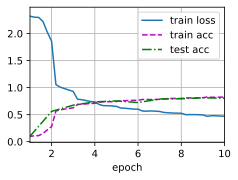

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和池化层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。

## 练习

1. 将平均池化层替换为最大池化层，会发生什么？
1. 尝试构建一个基于 LeNet 的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道的数量。
    1. 调整激活函数（如 ReLU）。
    1. 调整卷积层的数量。
    1. 调整全连接层的数量。
    1. 调整学习率和其他训练细节（例如，初始化和周期数）。
1. 在 MNIST 数据集上尝试以上改进的网络。
1. 显示不同输入（例如毛衣和外套）时，LeNet 第一层和第二层的激活值。


[Discussions](https://discuss.d2l.ai/t/1860)
